In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model
from keras.layers import Dense, LSTM
from keras.initializers import RandomNormal
from keras.models import Sequential

from data_utils import DataSimulator
from metrics import multimodel_accuracy
from losses import multimodel_exponential_loss
from simulator import simulate_ar_series

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [24]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


In [25]:
r_0 = 0

rho_dist_0 = lambda : random.uniform(-1, 1)
v_dist_0 = lambda: random.uniform(0, 0.006)

rho_dist_1 = lambda : np.random.beta(4, 4) * 2 - 1
# v_dist_1 = lambda: 0.006 * np.random.beta(2, 10)
v_dist_1 = lambda: random.uniform(0, 0.006)

rho_dist_2 = lambda : np.random.beta(3, 6) * 2 - 1
# v_dist_2 = lambda: 0.006 * np.random.beta(5, 1)
v_dist_2 = lambda: random.uniform(0, 0.006)



ar_models = [
    lambda s : [simulate_ar_series(r_0, rho_dist_0, v_dist_0, n=100, fixed=False) for _ in range(s)],
    lambda s : [simulate_ar_series(r_0, rho_dist_1, v_dist_1, n=100, fixed=False) for _ in range(s)],
    lambda s : [simulate_ar_series(r_0, rho_dist_2, v_dist_2, n=100, fixed=False) for _ in range(s)]
]


In [26]:
x = np.array(ar_models[1](4))

print(x.shape)


(4, 100, 1)


In [27]:
# Network
class BayesEvidenceNetwork(Model):
    def __init__(self, num_models, **kwargs):
        super().__init__(**kwargs)

        # shared backbone network
        self.summary_network = LSTM(128, return_sequences=False)
        self.intermediate_layer = Dense(128, activation='swish') 
        self.classification_network = Sequential([
            Dense(128, activation='swish'),
            Dense(128, activation='swish'),
            Dense(128, activation='swish'),
            Dense(128, activation='swish'),
            Dense(1)  # or more if multi-class
        ])

        self.output_layer = Dense(num_models-1, activation=None,
                                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # unbounded

    def call(self, x, training=False):
        x = self.summary_network(x, training=training)
        x= self.intermediate_layer(x, training=training)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)


In [28]:
# Data Preparation

BATCH_SIZE = 144
TRAIN_BATCHES = 144
VAL_BATCHES = 8
EPOCHS = 2

train_loader = DataSimulator(
    batches_per_epoch=TRAIN_BATCHES,
    simulators=ar_models,
    batch_size=BATCH_SIZE,
)

# Validation loader
val_loader = DataSimulator(
    batches_per_epoch=VAL_BATCHES,
    simulators=ar_models,
    batch_size=BATCH_SIZE,
)

In [29]:
# Compile model

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5, decay_steps=EPOCHS * len(train_loader)
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)

model = BayesEvidenceNetwork(len(ar_models))

model.compile(
    optimizer=optimizer,
    loss=multimodel_exponential_loss,
    metrics=[multimodel_accuracy]
)

In [30]:
# Train model

with torch.enable_grad(): 
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=EPOCHS,
        verbose=1
    )

Epoch 1/2
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 254ms/step - loss: 3.0000 - multimodel_accuracy: 0.3323 - val_loss: 3.0000 - val_multimodel_accuracy: 0.3325
Epoch 2/2
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - loss: 3.0000 - multimodel_accuracy: 0.3325 - val_loss: 3.0000 - val_multimodel_accuracy: 0.3316


In [31]:
num_models = len(ar_models)
cm = np.zeros((num_models, num_models), dtype=int)

# Fill confusion matrix
for idx, func in enumerate(ar_models):
    X_test = np.array(func(100))
    y_test = np.full((X_test.shape[0], 1), idx, dtype=np.int32)

    f_x = model.predict(X_test[:, :], verbose=0)

    y_pred = np.argmax(f_x, axis=1)

    for true_label, pred_label in zip(y_test.flatten(), y_pred):
        cm[true_label, pred_label] += 1

    acc = np.mean(y_pred == y_test.flatten())
    print(f"Model {idx} accuracy: {acc*100:.2f}%")

# Pretty print confusion matrix
print("\nConfusion Matrix:")
header = "Predicted ->\t" + "\t".join([f"{i}" for i in range(num_models)])
print(header)
for i in range(num_models):
    row = "\t".join([str(cm[i, j]) for j in range(num_models)])
    print(f"True {i}:     \t{row}")

Model 0 accuracy: 29.00%
Model 1 accuracy: 72.00%
Model 2 accuracy: 0.00%

Confusion Matrix:
Predicted ->	0	1	2
True 0:     	29	71	0
True 1:     	28	72	0
True 2:     	28	72	0



Loss History


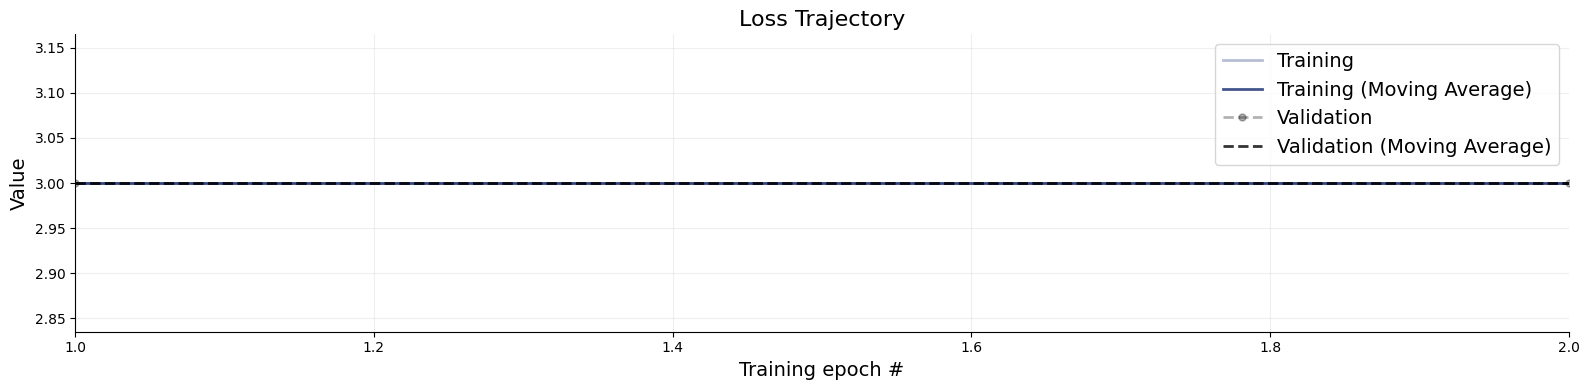

In [32]:
print(f"\nLoss History")
bf.diagnostics.plots.loss(history=history)
plt.show()